#  Assignment - Deepankar Kotnala

In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [2]:
warnings.filterwarnings('ignore')
np.random.seed(8)
%matplotlib inline

In [3]:
# Reading the data

customer_features = pd.read_csv('data/customer_features.csv')
last_month_assortment =pd.read_csv('data/last_month_assortment.csv')
next_month_assortment = pd.read_csv('data/next_month_assortment.csv')
next_purchase_order = pd.read_csv('data/next_purchase_order.csv')
original_purchase_order = pd.read_csv('data/original_purchase_order.csv')
product_features = pd.read_csv('data/product_features.csv')

### Exploratory Data Analysis and Data Preparation for Models

In [4]:
# Checking for duplicates

duplicateRows_cf = customer_features[customer_features.duplicated()]
print('Customer_features_duplicates',duplicateRows_cf.head())

duplicateRows_lm = last_month_assortment[last_month_assortment.duplicated()]
print('last_month_assortment_duplicates',duplicateRows_lm.head())

duplicateRows_nm = next_month_assortment[next_month_assortment.duplicated()]
print('next_month_assortment_duplicates',duplicateRows_nm.head())

duplicateRows_po = next_purchase_order[next_purchase_order.duplicated()]
print('next_purchase_order_duplicates',duplicateRows_po.head())

duplicateRows_op = original_purchase_order[original_purchase_order.duplicated()]
print('original_purchase_order_duplicates',duplicateRows_op.head())

duplicateRows_pf = product_features[product_features.duplicated()]
print('product_features_duplicates',duplicateRows_pf.head())

# No duplicates rows found

Customer_features_duplicates Empty DataFrame
Columns: [customer_id, age_bucket, is_returning_customer, favorite_genres]
Index: []
last_month_assortment_duplicates Empty DataFrame
Columns: [customer_id, product_id, purchased]
Index: []
next_month_assortment_duplicates Empty DataFrame
Columns: [customer_id, product_id]
Index: []
next_purchase_order_duplicates Empty DataFrame
Columns: [product_id, quantity_purchased, cost_to_buy, retail_value]
Index: []
original_purchase_order_duplicates Empty DataFrame
Columns: [product_id, quantity_purchased, cost_to_buy, retail_value]
Index: []
product_features_duplicates Empty DataFrame
Columns: [product_id, length, difficulty, fiction, genre]
Index: []


In [5]:
# Checking for NAs

print('customer_features: \n', customer_features.isnull().sum())
print('\n\n last_month_assortment: \n', last_month_assortment.isnull().sum())
print('\n\n next_month_assortment: \n', next_month_assortment.isnull().sum())
print('\n\n next_purchase_order: \n', next_purchase_order.isnull().sum())
print('\n\n original_purchase_order: \n', original_purchase_order.isnull().sum())
print('\n\n product_features: \n', product_features.isnull().sum())

# In customer features df, the age_bucket column is NULL for 500 customers

customer_features: 
 customer_id                0
age_bucket               500
is_returning_customer      0
favorite_genres            0
dtype: int64


 last_month_assortment: 
 customer_id    0
product_id     0
purchased      0
dtype: int64


 next_month_assortment: 
 customer_id    0
product_id     0
dtype: int64


 next_purchase_order: 
 product_id            0
quantity_purchased    0
cost_to_buy           0
retail_value          0
dtype: int64


 original_purchase_order: 
 product_id            0
quantity_purchased    0
cost_to_buy           0
retail_value          0
dtype: int64


 product_features: 
 product_id    0
length        0
difficulty    0
fiction       0
genre         0
dtype: int64


In [6]:
customer_features.head()

,customer_id,age_bucket,is_returning_customer,favorite_genres
0,1000078,46-55,True,"['Classic', 'History', 'Self-Help', 'Romance',..."
1,1000102,46-55,True,"['Beach-Read', 'Pop-Sci', 'Pop-Psychology', 'B..."
2,1000185,46-55,True,"['Romance', 'Self-Help', 'Beach-Read', 'Pop-Ps..."
3,1000423,26-35,True,"['Classic', 'Drama']"
4,1000696,66+,True,"['Drama', 'Thriller', 'Sci-Fi', 'Romance', 'Hi..."


#### Removing irregularities from favorite_genres column and converting it to a numeric array suitable for ML models

In [7]:
customer_features['favorite_genres'] = customer_features.favorite_genres.apply(lambda x: x.lower())
customer_features.head()

,customer_id,age_bucket,is_returning_customer,favorite_genres
0,1000078,46-55,True,"['classic', 'history', 'self-help', 'romance',..."
1,1000102,46-55,True,"['beach-read', 'pop-sci', 'pop-psychology', 'b..."
2,1000185,46-55,True,"['romance', 'self-help', 'beach-read', 'pop-ps..."
3,1000423,26-35,True,"['classic', 'drama']"
4,1000696,66+,True,"['drama', 'thriller', 'sci-fi', 'romance', 'hi..."


In [8]:
# removing the '-' from certain genres in favorite_genres column
customer_features['favorite_genres'] = customer_features.favorite_genres.apply(lambda x: x.replace("-", ""))
customer_features.head()

,customer_id,age_bucket,is_returning_customer,favorite_genres
0,1000078,46-55,True,"['classic', 'history', 'selfhelp', 'romance', ..."
1,1000102,46-55,True,"['beachread', 'popsci', 'poppsychology', 'biog..."
2,1000185,46-55,True,"['romance', 'selfhelp', 'beachread', 'poppsych..."
3,1000423,26-35,True,"['classic', 'drama']"
4,1000696,66+,True,"['drama', 'thriller', 'scifi', 'romance', 'his..."


In [9]:
# Count Vectorizer counts the number of words in each corpus and returns count of each word

cnv = CountVectorizer()
cnv.get_params

<bound method BaseEstimator.get_params of CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)>

In [10]:
# Converting favorite_genres column to multiple columnar format using Count Vectorizer 

vect = CountVectorizer(token_pattern='(?u)\\b\\w+\\b')
X_vect = vect.fit_transform(customer_features.favorite_genres)

genres_data = pd.DataFrame(X_vect.toarray(), columns=vect.get_feature_names())
customer_features = customer_features.join(genres_data)

to_drop = ['favorite_genres']
customer_features.drop(to_drop, inplace=True, axis=1)
customer_features.head()

,customer_id,age_bucket,is_returning_customer,beachread,biography,classic,drama,history,poppsychology,popsci,romance,scifi,selfhelp,thriller
0,1000078,46-55,True,1,0,1,0,1,1,1,1,1,1,1
1,1000102,46-55,True,1,1,0,1,0,1,1,0,1,1,0
2,1000185,46-55,True,1,0,0,0,0,1,0,1,0,1,0
3,1000423,26-35,True,0,0,1,1,0,0,0,0,0,0,0
4,1000696,66+,True,1,1,0,1,1,0,0,1,1,0,1


In [11]:
last_month_assortment.head()

,customer_id,product_id,purchased
0,1000078,1730073,False
1,1000078,1470520,False
2,1000078,1861356,False
3,1000078,1240824,True
4,1000078,1155460,False


In [12]:
# From this df, we can calculate the total shipping cost for each product 
# and the overall shipping cost incurred in the last month

# since shipping cost is 0.60 paise per side per book
last_month_assortment['shipping_cost'] = last_month_assortment.purchased.apply(lambda x: 0.6 if x==True else 1.2) 
last_month_assortment.head()

,customer_id,product_id,purchased,shipping_cost
0,1000078,1730073,False,1.2
1,1000078,1470520,False,1.2
2,1000078,1861356,False,1.2
3,1000078,1240824,True,0.6
4,1000078,1155460,False,1.2


In [13]:
product_features.head()

,product_id,length,difficulty,fiction,genre
0,1769808,148,3,False,Self-Help
1,1896283,161,5,False,Biography
2,1889979,296,4,False,History
3,1341288,551,4,True,Thriller
4,1666328,623,-1,True,Sci-Fi


In [14]:
# Creating a master dataframe by merging the provided dataframes

master_df = pd.merge(product_features, last_month_assortment, on ='product_id')
master_df.head()

,product_id,length,difficulty,fiction,genre,customer_id,purchased,shipping_cost
0,1769808,148,3,False,Self-Help,1024268,False,1.2
1,1769808,148,3,False,Self-Help,1029037,False,1.2
2,1769808,148,3,False,Self-Help,1040471,False,1.2
3,1769808,148,3,False,Self-Help,1049982,False,1.2
4,1769808,148,3,False,Self-Help,1064903,True,0.6


In [15]:
original_purchase_order.head()

,product_id,quantity_purchased,cost_to_buy,retail_value
0,1769808,77,2.20,16.67
1,1896283,67,1.46,9.59
2,1889979,80,2.06,13.36
3,1341288,85,1.25,6.57
4,1666328,60,1.51,10.49


In [16]:
master_df = pd.merge(master_df, original_purchase_order, on ='product_id')
master_df.head()

,product_id,length,difficulty,fiction,genre,customer_id,purchased,shipping_cost,quantity_purchased,cost_to_buy,retail_value
0,1769808,148,3,False,Self-Help,1024268,False,1.2,77,2.2,16.67
1,1769808,148,3,False,Self-Help,1029037,False,1.2,77,2.2,16.67
2,1769808,148,3,False,Self-Help,1040471,False,1.2,77,2.2,16.67
3,1769808,148,3,False,Self-Help,1049982,False,1.2,77,2.2,16.67
4,1769808,148,3,False,Self-Help,1064903,True,0.6,77,2.2,16.67


In [17]:
master_df = pd.merge(master_df, customer_features, on='customer_id')
master_df.head()

,product_id,length,difficulty,fiction,genre,customer_id,purchased,shipping_cost,quantity_purchased,cost_to_buy,...,biography,classic,drama,history,poppsychology,popsci,romance,scifi,selfhelp,thriller
0,1769808,148,3,False,Self-Help,1024268,False,1.2,77,2.20,...,0,1,0,0,0,0,0,0,0,1
1,1541404,431,1,True,Drama,1024268,False,1.2,64,2.01,...,0,1,0,0,0,0,0,0,0,1
2,1049883,264,5,True,Thriller,1024268,False,1.2,64,1.31,...,0,1,0,0,0,0,0,0,0,1
3,1557093,896,-1,True,Romance,1024268,False,1.2,96,2.18,...,0,1,0,0,0,0,0,0,0,1
4,1124997,956,1,False,History,1024268,False,1.2,99,1.66,...,0,1,0,0,0,0,0,0,0,1


In [18]:
master_df.columns

Index(['product_id', 'length', 'difficulty', 'fiction', 'genre', 'customer_id',
       'purchased', 'shipping_cost', 'quantity_purchased', 'cost_to_buy',
       'retail_value', 'age_bucket', 'is_returning_customer', 'beachread',
       'biography', 'classic', 'drama', 'history', 'poppsychology', 'popsci',
       'romance', 'scifi', 'selfhelp', 'thriller'],
      dtype='object')


### Calculations

In [108]:
def calculate_loan(df_qty, df_cost):
    df_total_cost = df_qty*df_cost
    return round(sum(df_total_cost),2)

prev_month_cost = round(sum(master_df['shipping_cost']),2)
print('last month total shipping cost:', prev_month_cost)


prev_month_loan = calculate_loan(original_purchase_order['quantity_purchased'], original_purchase_order['cost_to_buy'])
print('last_month_loan: ', last_month_loan)

next_month_cost = calculate_loan(next_purchase_order['quantity_purchased'], next_purchase_order['cost_to_buy'])
print('next_month_cost: ', next_month_cost)

last month total shipping cost: 35592.6
previous month sales:  151617.36
last_month_loan:  135546.42
next_month_cost:  24155.51


In [20]:
def generate_accuracy_and_heatmap(model, x, y):
    cm = confusion_matrix(y,model.predict(x))
    sns.heatmap(cm,annot=True, fmt="d")
    
    ac=accuracy_score(y, model.predict(x))
    f_score = f1_score(y, model.predict(x))
    print('Accuracy is: ', ac)
    print('F1 Score is: ', f_score)
    print('\n')
    print(pd.crosstab(pd.Series(model.predict(x), name='Predicted'),
                      pd.Series(y['purchased'], name='Actual')))
    return 1

In [21]:
numeric_feature_columns = list(master_df._get_numeric_data().columns)
numeric_feature_columns

['product_id',
 'length',
 'difficulty',
 'fiction',
 'customer_id',
 'purchased',
 'shipping_cost',
 'quantity_purchased',
 'cost_to_buy',
 'retail_value',
 'is_returning_customer',
 'beachread',
 'biography',
 'classic',
 'drama',
 'history',
 'poppsychology',
 'popsci',
 'romance',
 'scifi',
 'selfhelp',
 'thriller']

In [22]:
target='purchased'

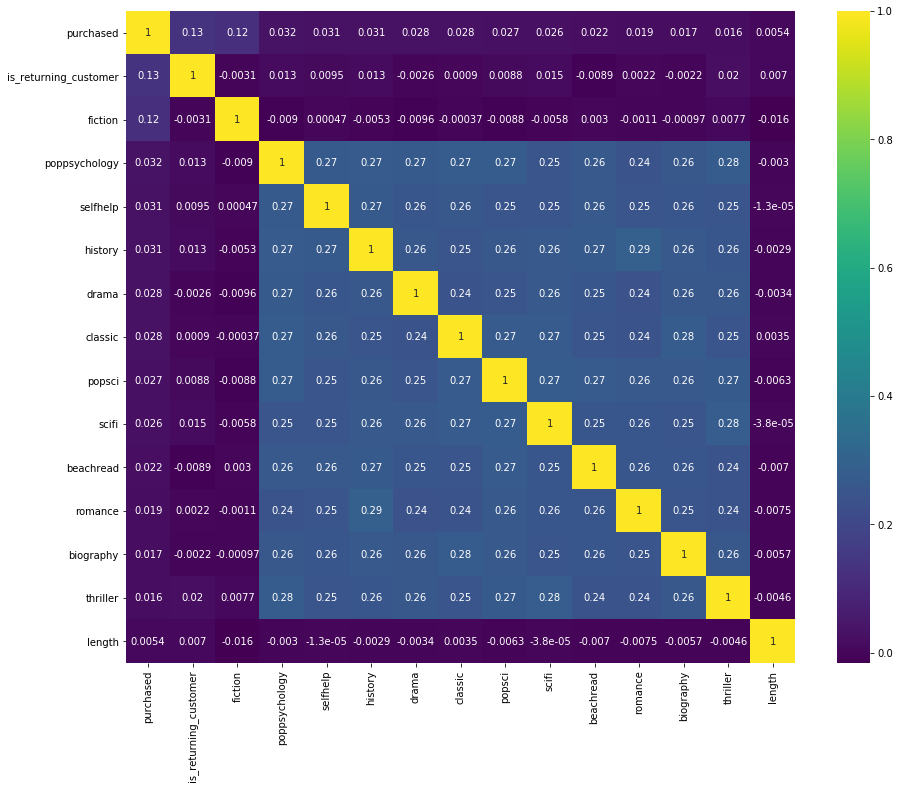

In [23]:
k=15   # number of variables for heatmap
cols = master_df[numeric_feature_columns].corr().nlargest(k, target)[target].index
cm = master_df[cols].corr()
from matplotlib import figure
plt.figure( figsize =(15,12) )
sns.heatmap(cm, annot=True, cmap='viridis')
#plt.show()

In [24]:
# Using label encoder to convert age_group to numerical code (or group)
le = LabelEncoder()
master_df['age_bucket'] = master_df['age_bucket'].astype(str)
master_df['age_bucket'] = le.fit_transform(master_df['age_bucket'])
master_df['fiction'] = le.fit_transform(master_df['fiction'])
master_df['genre'] = le.fit_transform(master_df['genre'])
master_df['is_returning_customer'] = le.fit_transform(master_df['is_returning_customer'])
master_df['purchased'] = le.fit_transform(master_df['purchased'])
master_df.head()

,product_id,length,difficulty,fiction,genre,customer_id,purchased,shipping_cost,quantity_purchased,cost_to_buy,...,biography,classic,drama,history,poppsychology,popsci,romance,scifi,selfhelp,thriller
0,1769808,148,3,0,9,1024268,0,1.2,77,2.20,...,0,1,0,0,0,0,0,0,0,1
1,1541404,431,1,1,3,1024268,0,1.2,64,2.01,...,0,1,0,0,0,0,0,0,0,1
2,1049883,264,5,1,10,1024268,0,1.2,64,1.31,...,0,1,0,0,0,0,0,0,0,1
3,1557093,896,-1,1,7,1024268,0,1.2,96,2.18,...,0,1,0,0,0,0,0,0,0,1
4,1124997,956,1,0,4,1024268,0,1.2,99,1.66,...,0,1,0,0,0,0,0,0,0,1


## Model Building

In [25]:
predictors = ['retail_value', 'length', 'difficulty','fiction', 'genre', 'age_bucket', 
                'is_returning_customer', 'beachread', 'biography', 'classic', 'drama', 'history', 
                'poppsychology', 'popsci', 'romance', 'scifi', 'selfhelp', 'thriller']
#Y = master_df['purchased']
X = master_df[predictors]


#X = master_df.loc[:, master_df.columns != target]
Y = master_df.loc[:, master_df.columns == target] 

In [26]:
X.shape

(36000, 18)

In [27]:
Y.shape

(36000, 1)

In [28]:
x_train, x_test, y_train, y_test = train_test_split(X, Y,
                                                   test_size=0.33,
                                                   random_state=8)

In [29]:
clf_lr = LogisticRegression()
lr_baseline_model = clf_lr.fit(x_train,y_train)

Accuracy is:  0.647895622896
F1 Score is:  0.0


Actual        0     1
Predicted            
0          2506  1345


1

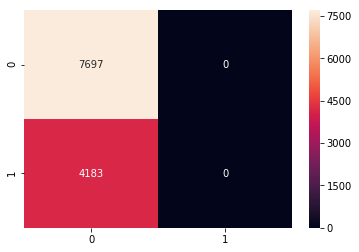

In [30]:
generate_accuracy_and_heatmap(lr_baseline_model, x_test, y_test)

# And it's a mess . . . 

In [31]:
# Let's try GridSearchCV to improve things

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
svmmodel = SVC()
svmmodel.fit(x_train,y_train)
predictions = svmmodel.predict(x_test)

In [32]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[6391 1306]
 [1657 2526]]
             precision    recall  f1-score   support

          0       0.79      0.83      0.81      7697
          1       0.66      0.60      0.63      4183

avg / total       0.75      0.75      0.75     11880



In [33]:
# Find the best 'C' value
param_grid = {'C': [0.1,1, 10, 100, 1000]}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=3)
grid.fit(x_train,y_train)  
grid.best_params_
c_val = grid.best_estimator_.C

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] C=0.1 ...........................................................
[CV] .................. C=0.1, score=0.7235074626865672, total=  27.0s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   40.9s remaining:    0.0s


[CV] .................. C=0.1, score=0.7145522388059702, total=  27.0s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s


[CV] .................. C=0.1, score=0.7199004975124378, total=  27.4s
[CV] C=1 .............................................................
[CV] .................... C=1, score=0.7460199004975124, total=  36.7s
[CV] C=1 .............................................................
[CV] .................... C=1, score=0.7420398009950249, total=  37.3s
[CV] C=1 .............................................................
[CV] .................... C=1, score=0.7475124378109452, total=  36.8s
[CV] C=10 ............................................................
[CV] ................... C=10, score=0.6998756218905473, total= 1.1min
[CV] C=10 ............................................................
[CV] ................... C=10, score=0.7044776119402985, total= 1.0min
[CV] C=10 ............................................................
[CV] ................... C=10, score=0.6956467661691542, total=  60.0s
[CV] C=100 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 18.1min finished


In [34]:
print('grid.best_estimator_.C : ', c_val)
print('Best Parameter Value: ', grid.best_params_)

grid.best_estimator_.C :  1
Best Parameter Value:  {'C': 1}


In [35]:
# Now we can re-run predictions on this grid object just like we would with a normal model.
grid_predictions = grid.predict(x_test)

# We will use the best 'C' value found by GridSearch and reload our LogisticRegression module
logmodel = LogisticRegression(C=c_val)
logmodel.fit(x_train,y_train)

print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))

# Now things are looking good!!

[[6391 1306]
 [1657 2526]]
             precision    recall  f1-score   support

          0       0.79      0.83      0.81      7697
          1       0.66      0.60      0.63      4183

avg / total       0.75      0.75      0.75     11880



In [36]:
# We will use the best 'C' value found by GridSearch and reload our SVM module
svm_model = SVC(C=c_val)
svm_model.fit(x_train,y_train)

print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))

[[6391 1306]
 [1657 2526]]
             precision    recall  f1-score   support

          0       0.79      0.83      0.81      7697
          1       0.66      0.60      0.63      4183

avg / total       0.75      0.75      0.75     11880



In [37]:
y_pred = logmodel.predict(x_test)
print('Accuracy of Logistic Regression classifier on test set: {:.2f}'.format(metrics.accuracy_score(y_test, y_pred)))

Accuracy of Logistic Regression classifier on test set: 0.65


In [38]:
y_pred = svm_model.predict(x_test)
print('Accuracy of Support vector Machine classifier on test set: {:.2f}'.format(metrics.accuracy_score(y_test, y_pred)))

Accuracy of Support vector Machine classifier on test set: 0.75


In [39]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(C=c_val)
xgb_model.fit(x_train, y_train)

XGBClassifier(C=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [40]:
y_pred = xgb_model.predict(x_test)
print('Accuracy of adaboost classifier on test set: {:.2f}'.format(metrics.accuracy_score(y_test, y_pred)))

Accuracy of adaboost classifier on test set: 0.76


Accuracy is:  0.761111111111
F1 Score is:  0.64364640884


Actual        0    1
Predicted           
0          1691  893
1           815  452


1

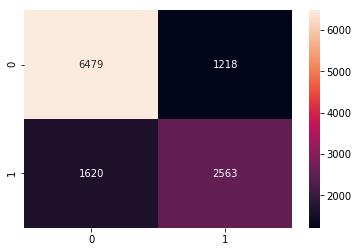

In [41]:
generate_accuracy_and_heatmap(xgb_model, x_test, y_test)

In [46]:
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test, xgb_model.predict(x_test))
print('Confusion Matrix : \n', cm1)

total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

Confusion Matrix : 
 [[6479 1218]
 [1620 2563]]
Accuracy :  0.761111111111
Sensitivity :  0.841756528518
Specificity :  0.612718144872




## So we will go with XG Boost Algorithm!
---------------------------------------------------------
Confusion Matrix : 

 [[6479 1218]
 
 [1620 2563]]
 
Accuracy :  0.761111111111

Sensitivity :  0.841756528518

Specificity :  0.612718144872

---------------------------------------------------------


In [70]:
#Let's find out how many books from previous month are left 
temp_df = pd.DataFrame(last_month_assortment.groupby(['product_id'])['purchased'].sum().reset_index())
temp_df.head()

,product_id,purchased
0,1003455,6.0
1,1004302,18.0
2,1007659,29.0
3,1008476,4.0
4,1009975,4.0


In [71]:
prev_month_books_remaining = pd.merge(original_purchase_order, temp_df, on = 'product_id')
prev_month_books_remaining['quantity_remaining'] = prev_month_books_remaining['quantity_purchased'] - prev_month_books_remaining['purchased']
prev_month_books_remaining = prev_month_books_remaining.drop(columns = ['quantity_purchased', 'purchased'])
prev_month_books_remaining.head()

,product_id,cost_to_buy,retail_value,quantity_remaining
0,1769808,2.20,16.67,69.0
1,1896283,1.46,9.59,65.0
2,1889979,2.06,13.36,74.0
3,1341288,1.25,6.57,56.0
4,1666328,1.51,10.49,40.0


In [69]:
#Let's make predictions for next month's assortment:
next_purchase_order.head()

,product_id,quantity_purchased,cost_to_buy,retail_value
0,1479507,39,1.82,12.68
1,1681385,55,1.73,12.88
2,1771749,37,1.26,10.38
3,1605149,49,1.47,11.27
4,1861356,34,1.98,10.41


In [137]:
next_month_assortment.head()

,customer_id,product_id
0,1600785,1443029
1,1600785,1164138
2,1600785,1636511
3,1600785,1832547
4,1600785,1237420


In [142]:
prev_month_sales_df = pd.merge(original_purchase_order, last_month_assortment, on ='product_id')
prev_month_sales_df.head()

,product_id,quantity_purchased,cost_to_buy,retail_value,customer_id,purchased,shipping_cost
0,1769808,77,2.2,16.67,1024268,False,1.2
1,1769808,77,2.2,16.67,1029037,False,1.2
2,1769808,77,2.2,16.67,1040471,False,1.2
3,1769808,77,2.2,16.67,1049982,False,1.2
4,1769808,77,2.2,16.67,1064903,True,0.6


In [141]:
total_sales_prev_month = round(sum(prev_month_sales_df['retail_value'].where(prev_month_sales_df['purchased']==True, 0)),2)
total_sales_prev_month

151617.36

In [129]:
next_month_pred = pd.merge(next_month_assortment, prev_month_books_remaining, on = 'product_id')
next_month_pred = pd.merge(next_month_pred, customer_features, on = 'customer_id')
next_month_pred = pd.merge(next_month_pred, product_features, on = 'product_id')
next_month_pred.head()

,customer_id,product_id,cost_to_buy,retail_value,quantity_remaining,age_bucket,is_returning_customer,beachread,biography,classic,...,poppsychology,popsci,romance,scifi,selfhelp,thriller,length,difficulty,fiction,genre
0,1600785,1443029,2.27,12.88,60.0,56-65,False,0,1,1,...,1,1,1,1,1,1,266,1,True,Sci-Fi
1,1601264,1443029,2.27,12.88,60.0,56-65,True,1,1,0,...,0,0,1,0,1,1,266,1,True,Sci-Fi
2,1604824,1443029,2.27,12.88,60.0,46-55,True,0,0,0,...,0,0,0,0,0,0,266,1,True,Sci-Fi
3,1659117,1443029,2.27,12.88,60.0,36-45,False,0,0,0,...,0,0,0,0,0,0,266,1,True,Sci-Fi
4,1680221,1443029,2.27,12.88,60.0,46-55,True,1,1,1,...,1,1,0,0,0,0,266,1,True,Sci-Fi


In [130]:
next_month_pred['age_bucket'] = next_month_pred['age_bucket'].astype(str)
next_month_pred['fiction'] = le.fit_transform(next_month_pred['fiction'])
next_month_pred['genre'] = le.fit_transform(next_month_pred['genre'])
next_month_pred['age_bucket'] = le.fit_transform(next_month_pred['age_bucket'])
next_month_pred['is_returning_customer'] = le.fit_transform(next_month_pred['is_returning_customer'])
next_month_pred.head()

,customer_id,product_id,cost_to_buy,retail_value,quantity_remaining,age_bucket,is_returning_customer,beachread,biography,classic,...,poppsychology,popsci,romance,scifi,selfhelp,thriller,length,difficulty,fiction,genre
0,1600785,1443029,2.27,12.88,60.0,5,0,0,1,1,...,1,1,1,1,1,1,266,1,1,8
1,1601264,1443029,2.27,12.88,60.0,5,1,1,1,0,...,0,0,1,0,1,1,266,1,1,8
2,1604824,1443029,2.27,12.88,60.0,4,1,0,0,0,...,0,0,0,0,0,0,266,1,1,8
3,1659117,1443029,2.27,12.88,60.0,3,0,0,0,0,...,0,0,0,0,0,0,266,1,1,8
4,1680221,1443029,2.27,12.88,60.0,4,1,1,1,1,...,1,1,0,0,0,0,266,1,1,8


In [131]:
features_for_prediction = ['retail_value', 'length', 'difficulty','fiction', 'genre', 'age_bucket', 
                'is_returning_customer', 'beachread', 'biography', 'classic', 'drama', 'history', 
                'poppsychology', 'popsci', 'romance', 'scifi', 'selfhelp', 'thriller']
X = next_month_pred[features_for_prediction]
X.head()

,retail_value,length,difficulty,fiction,genre,age_bucket,is_returning_customer,beachread,biography,classic,drama,history,poppsychology,popsci,romance,scifi,selfhelp,thriller
0,12.88,266,1,1,8,5,0,0,1,1,0,1,1,1,1,1,1,1
1,12.88,266,1,1,8,5,1,1,1,0,0,1,0,0,1,0,1,1
2,12.88,266,1,1,8,4,1,0,0,0,0,0,0,0,0,0,0,0
3,12.88,266,1,1,8,3,0,0,0,0,0,0,0,0,0,0,0,0
4,12.88,266,1,1,8,4,1,1,1,1,0,0,1,1,0,0,0,0


In [82]:
print(X.shape)
print(len(next_pred['product_id'].unique()))

(56400, 18)
1000


In [132]:
predict_next_month_purchase = xgb_model.predict(X)
print('Number of books predicted to be purchased: ',sum(predict_next_month_purchase))
sum(predict_next_month_purchase)/X.shape[0]

Number of books predicted to be purchased:  15171


0.26898936170212767

In [133]:
# Calculating the shipping cost for next month's prediction
next_month_shipping = (sum(predict_next_month_purchase)*0.6 + (X.shape[0]-sum(predict_next_month_purchase)*1.2))
print('Shipping cost predictions for next month\'s assortment: ', next_month_shipping)

Shipping cost predictions for next month's assortment:  47297.4


In [134]:
#calculate sales for next month:
next_month_pred['next_month_purchase_predictions'] = predict_next_month_purchase
#data_next.head()
next_sales = round(sum(next_month_pred['retail_value'].where(next_month_pred['next_month_purchase_predictions']==1, 0)),2)
print("Sale prediction for next month: ", next_sales)

Sale prediction for next month:  182383.15


In [136]:
# Will we be able to pay back loan and afford next book purchase?
tot_cost = last_month_loan + next_month_cost + last_month_shipping_cost + next_month_shipping
tot_sales = total_sales_prev_month + next_sales
print(" Total Profit/Loss (Profit will be Positive, Loss will be Negative) \n Formula = (Total Sales - Total Cost to Us) =", total_sales - total_cost_to_us)

 Total Profit/Loss (Profit will be Positive, Loss will be Negative) 
 Formula = (Total Sales - Total Cost to Us) = 91408.58


In [128]:
Final_Decision = ('Yes' if (tot_sales - tot_cost > 0) else 'No')
print(Final_Decision)

Yes
